# Import

In [44]:
%pip install -q pandas seaborn matplotlib missingno statsmodels fastparquet scikit-learn altair plotly

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import seaborn as sns 
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import altair as alt

plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# Constants

In [2]:
TRAIN_PATH = "../../data/train/df_train_ID_"
TEST_PATH = "../../data/test/df_test_ID_"
DATASET_PATH = "../../data/dataset/df_ID_"
MODELS =  "../../data/models/"
DATA_PATH =  "../../data/detection_fuite.csv" 
x = "valeur_active"

# Exploratory Data Analysis

In [3]:
def wrangle(path):
     
    df = pd.read_csv(DATA_PATH, parse_dates=["valeur_date"], index_col=["valeur_date"])

    #select from id_1 to id_20
    ids = [f"ID_{i}" for i in range(1, 21)]
    new_df = df[df["libelle"].isin(ids)]
    return new_df


In [4]:
df = pd.read_csv(DATA_PATH, parse_dates=["valeur_date"], index_col=["valeur_date"])
df.sample(5)

,valeur_active,libelle
valeur_date,,
2022-06-09,0.0,ID_236
2024-05-08,16.0,ID_317
2022-07-02,5.0,ID_332
2022-03-10,0.0,ID_53
2022-05-13,5.0,ID_318


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470900 entries, 2019-01-01 to 2024-12-31
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   valeur_active  448808 non-null  float64
 1   libelle        470900 non-null  object 
dtypes: float64(1), object(1)
memory usage: 10.8+ MB


In [6]:
df.describe()

,valeur_active
count,4.488080e+05
mean,1.160575e+03
std,3.013335e+05
min,-8.740000e+01
25%,7.972603e-01
50%,5.100000e+00
75%,2.000000e+01
max,9.999999e+07


## Extract measurements from ID_1 to ID_20

In [7]:
ids = [f"ID_{i}" for i in range(1, 21)]
df_filtered = df[df["libelle"].isin(ids)]
df_filtered.sample(5)

,valeur_active,libelle
valeur_date,,
2021-07-28,130.699997,ID_12
2023-05-10,126.000000,ID_9
2024-10-12,0.070000,ID_11
2019-02-09,156.910004,ID_8
2021-01-31,42.200001,ID_12


In [8]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39428 entries, 2019-01-01 to 2024-12-31
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   valeur_active  39144 non-null  float64
 1   libelle        39428 non-null  object 
dtypes: float64(1), object(1)
memory usage: 924.1+ KB


In [9]:
data = []
for libelle in df_filtered["libelle"].unique():
    data.append(
        {
            "libelle": libelle,
            "nr_of_missing_values_before_resampling": int(df_filtered[df_filtered["libelle"] == libelle]["valeur_active"].isna().sum()),
            "nr_of_missing_values_after_resampling": int(df_filtered[df_filtered["libelle"] == libelle]
                                                            .resample("D")
                                                            .first()[x]
                                                            .isna()
                                                            .sum()),            
        })

In [10]:
nr_samples = 2192
df_stats = pd.DataFrame(data)
df_stats["pct_missing_values[%]"] = round((df_stats["nr_of_missing_values_after_resampling"]/nr_samples) * 100, 2)
df_stats.sort_values(by="pct_missing_values[%]", ascending=False)
df_stats.head()

,libelle,nr_of_missing_values_before_resampling,nr_of_missing_values_after_resampling,pct_missing_values[%]
0,ID_1,91,509,23.22
1,ID_2,7,39,1.78
2,ID_3,8,43,1.96
3,ID_4,13,25,1.14
4,ID_5,1,5,0.23


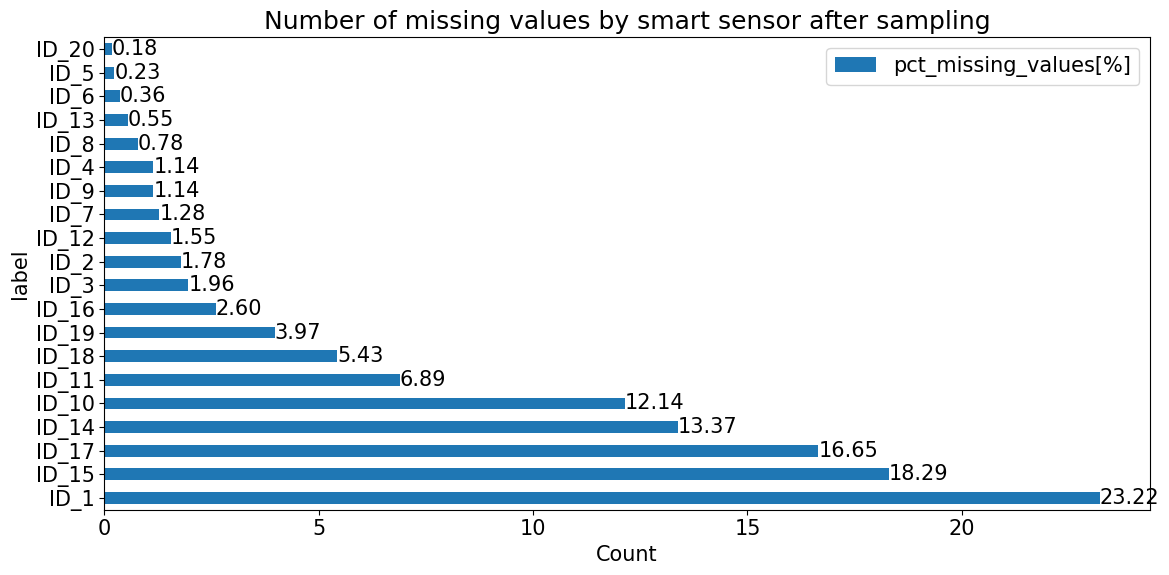

In [11]:
ax = (
    df_stats.sort_values(by="pct_missing_values[%]", ascending=False)
    .plot(kind="barh", 
          x="libelle", 
          y="pct_missing_values[%]", 
          xlabel="Count", 
          title="Number of missing values by smart sensor after sampling", 
          ylabel="label")
)

# Ajout des valeurs au bout des barres
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge")

plt.tight_layout()
plt.show()

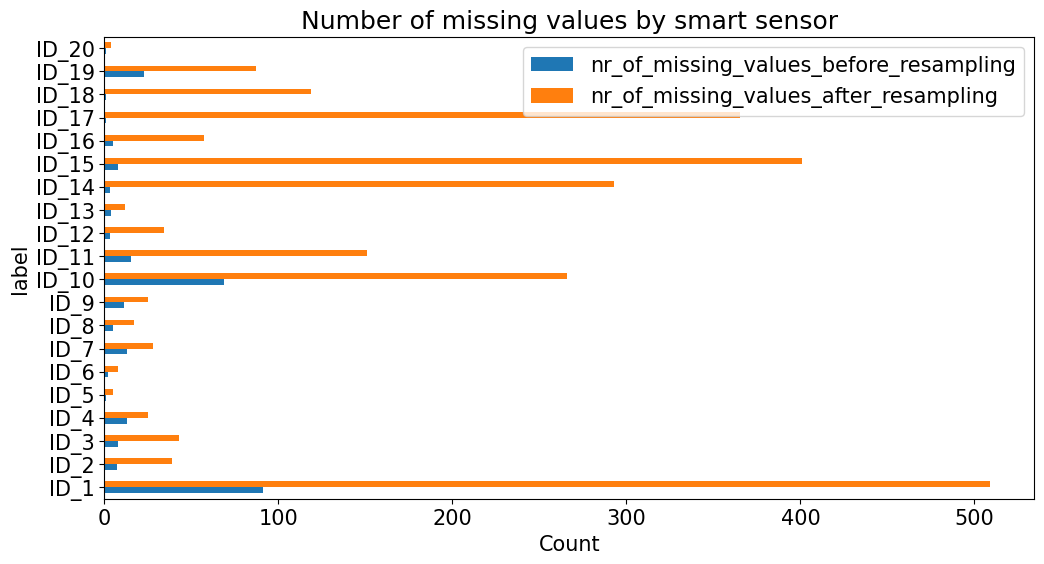

In [12]:
pd.DataFrame(data).plot(kind="barh", x="libelle", xlabel="Count", title="Number of missing values by smart sensor", ylabel="label");

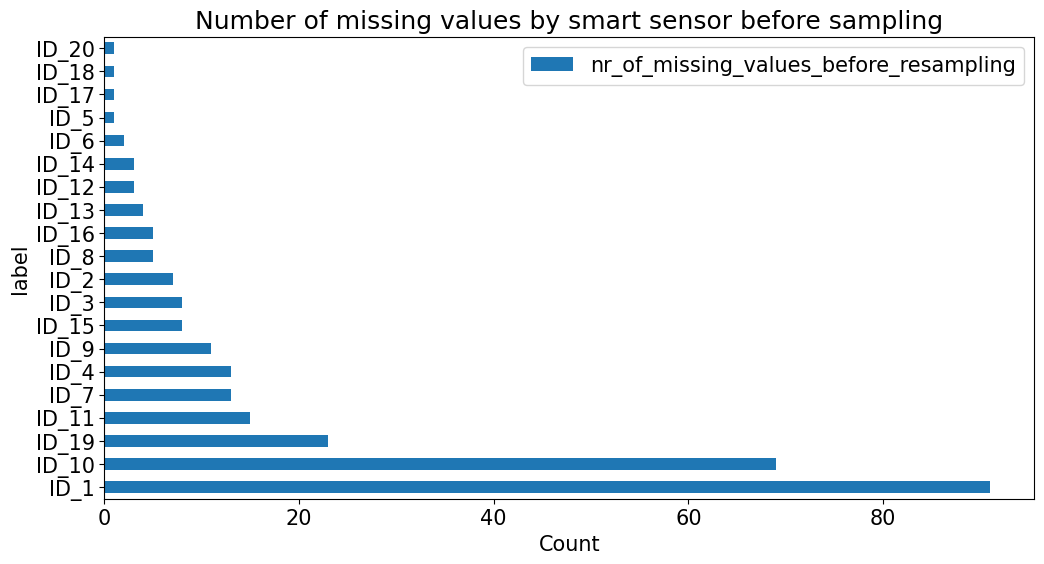

In [13]:
(
    pd.DataFrame(data).sort_values(by="nr_of_missing_values_before_resampling", ascending=False)
    .plot(kind="barh", x="libelle", y="nr_of_missing_values_before_resampling", xlabel="Count", title="Number of missing values by smart sensor before sampling", ylabel="label")

);

## EDA of Smart meters

Our analysis consists of the following steps: 

- handling missing values ;
- performing univariate and bivariate analysis;
- performing autocorrelation analysis;
- analyzing trends, seasonality and stationarity.

The smart meters 1 and 5 are analyzed in this notebook

### ID_5

In [14]:
# Extract ID_5 data
df_id_5 = df_filtered[df_filtered["libelle"] == "ID_5"]
df_id_5.sample(5)

,valeur_active,libelle
valeur_date,,
2023-12-18,29.0,ID_5
2024-02-18,30.0,ID_5
2023-04-02,28.0,ID_5
2019-01-22,38.0,ID_5
2019-04-06,36.0,ID_5


#### Resampling and handling missing values

In [15]:
df_id_5 = df_id_5.resample("D").first()

In [16]:
#Find the missing values
df_id_5[df_id_5[x].isna()]

,valeur_active,libelle
valeur_date,,
2019-08-11,NaN,None
2024-05-27,NaN,None
2024-12-19,NaN,ID_5
2024-12-20,NaN,None
2024-12-23,NaN,None


In [17]:
# Check values of the days before and after 2014-12-19
df_id_5.loc["2024-12-10":"2024-12-26"]

,valeur_active,libelle
valeur_date,,
2024-12-10,31.0,ID_5
2024-12-11,31.0,ID_5
2024-12-12,32.0,ID_5
2024-12-13,31.0,ID_5
2024-12-14,31.0,ID_5
2024-12-15,30.0,ID_5
2024-12-16,30.0,ID_5
2024-12-17,32.0,ID_5
2024-12-18,32.0,ID_5


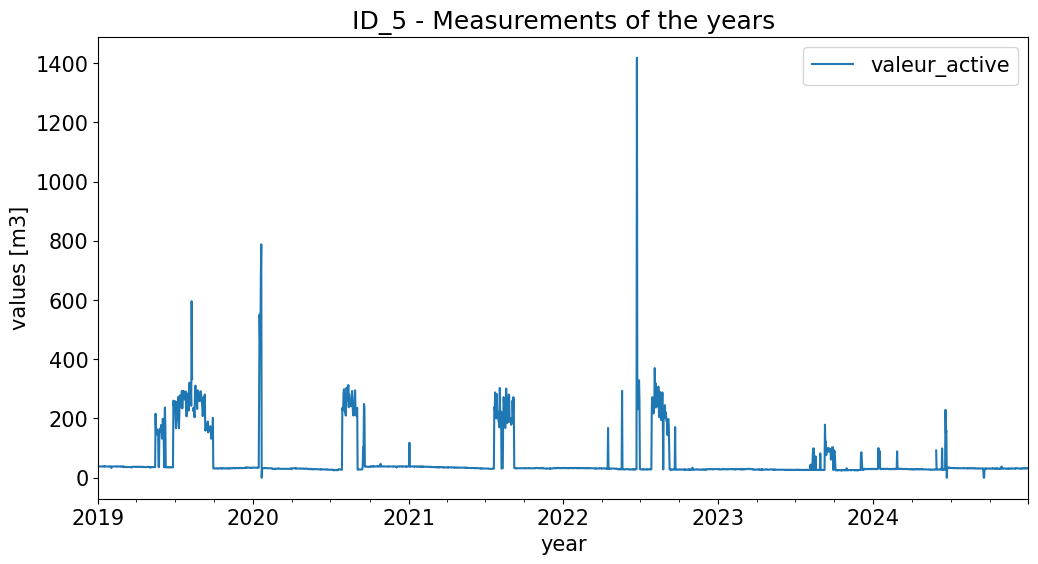

In [18]:
nr_id = "ID_5"
df_id_5.plot(
    xlabel="year", 
    ylabel="values [m3]",
    title=f"{nr_id} - Measurements of the years"
);

**Comment** : 
The visualization of our data shows the presence of seasonality. Water consumption varies very little from one day to the next within the same season (winter, summer, spring, autumn).

We will therefore use the backward-fill method, which replaces each NaN value with the value from the previous day.

In [19]:
df_id_5[x] = df_id_5[x].ffill()

#### Visualization

##### Univariate analysis

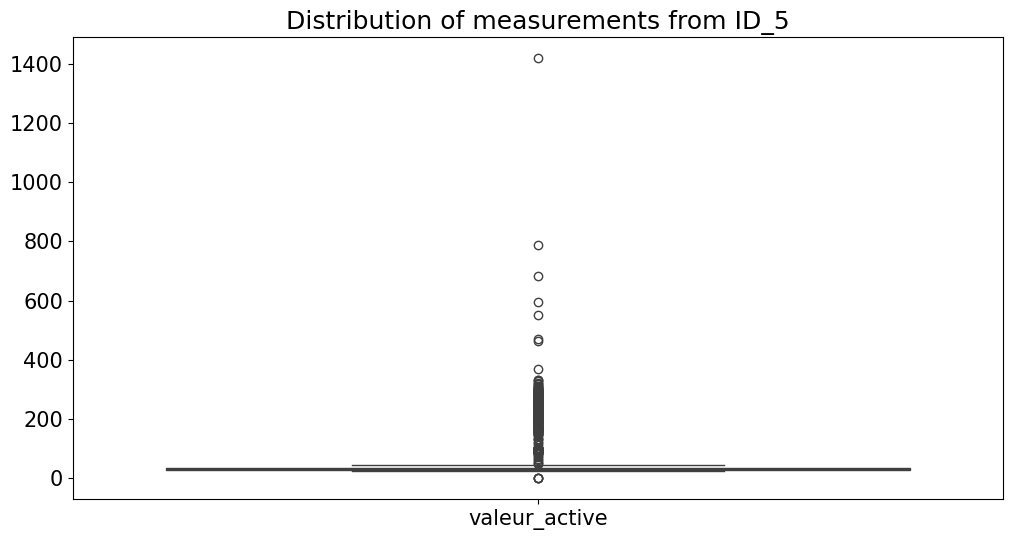

In [20]:
sns.boxplot(df_id_5)
plt.title(f"Distribution of measurements from {nr_id}");

**Comment** : 
- The distribution is skewed at right  

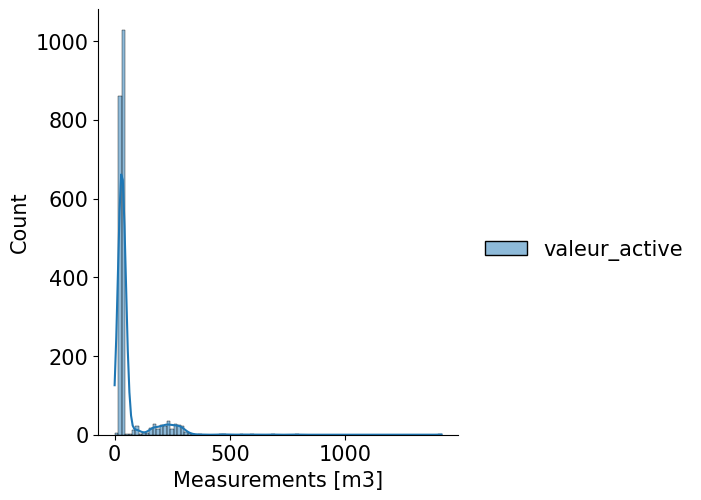

In [21]:
sns.displot(df_id_5, kde=True)
plt.xlabel("Measurements [m3]");

#### Bivariate analysis

##### Measurements by month

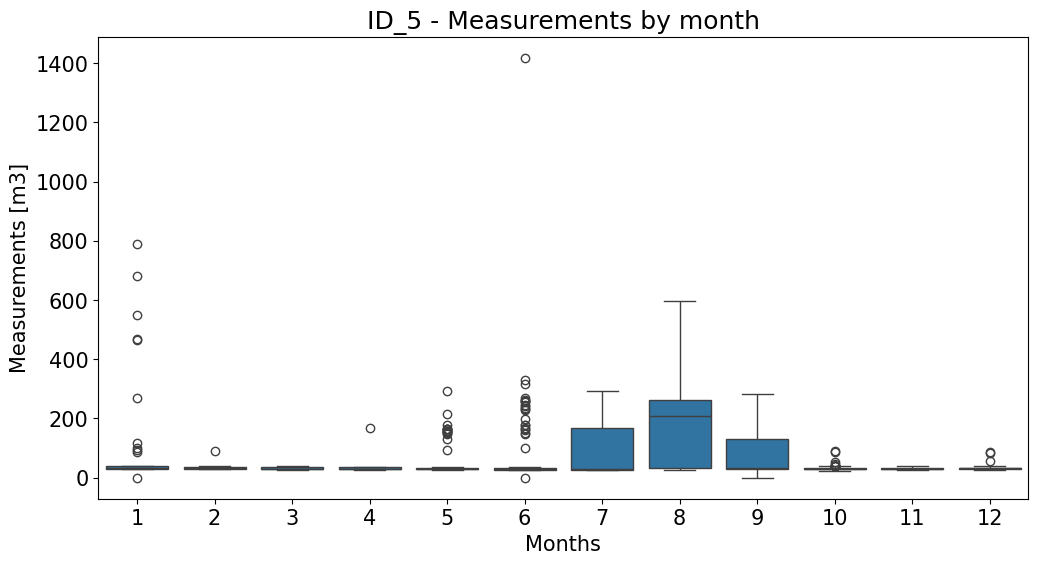

In [22]:
sns.boxplot(data=df_id_5, x=df_id_5.index.month, y="valeur_active")
plt.ylabel("Measurements [m3]")
plt.xlabel("Months")
plt.title(f"{nr_id} - Measurements by month");

##### Measurements by year

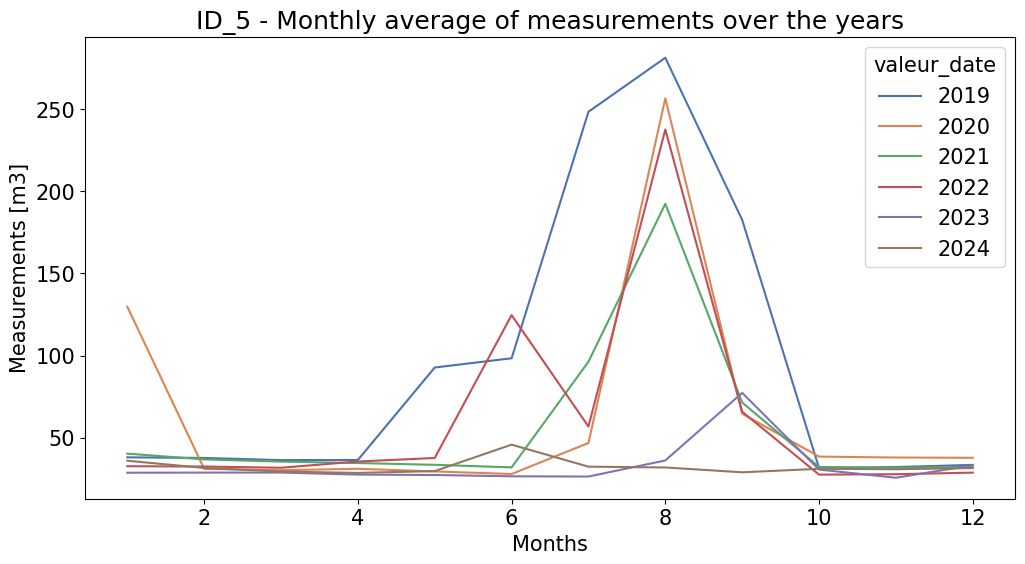

In [23]:
sns.lineplot(data=df_id_5, x=df_id_5.index.month, y="valeur_active", hue=df_id_5.index.year, palette="deep", errorbar=None)
plt.ylabel("Measurements [m3]")
plt.xlabel("Months")
plt.title(f"{nr_id} - Monthly average of measurements over the years");

##### Measurements by season

In [24]:
#defining function
def get_season(month):
  x = month%12 // 3 + 1
  if x == 1:
    season = "Winter"
  if x == 2:
    season = "Spring"
  if x == 3:
    season = "Summer"
  if x == 4:
    season = "Autumn"
  return season
    
seasons = [get_season(month) for month in df_id_5.index.month]

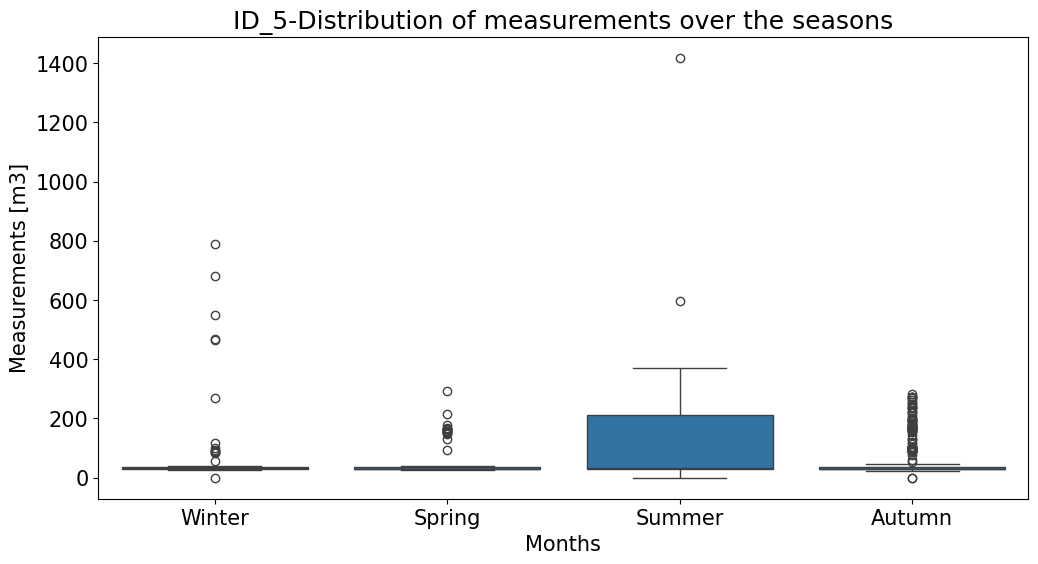

In [25]:
sns.boxplot(data=df_id_5, x=seasons, y="valeur_active")
plt.ylabel("Measurements [m3]")
plt.xlabel("Months")
plt.title(f"{nr_id}-Distribution of measurements over the seasons");

#### Autocorrelation

resource

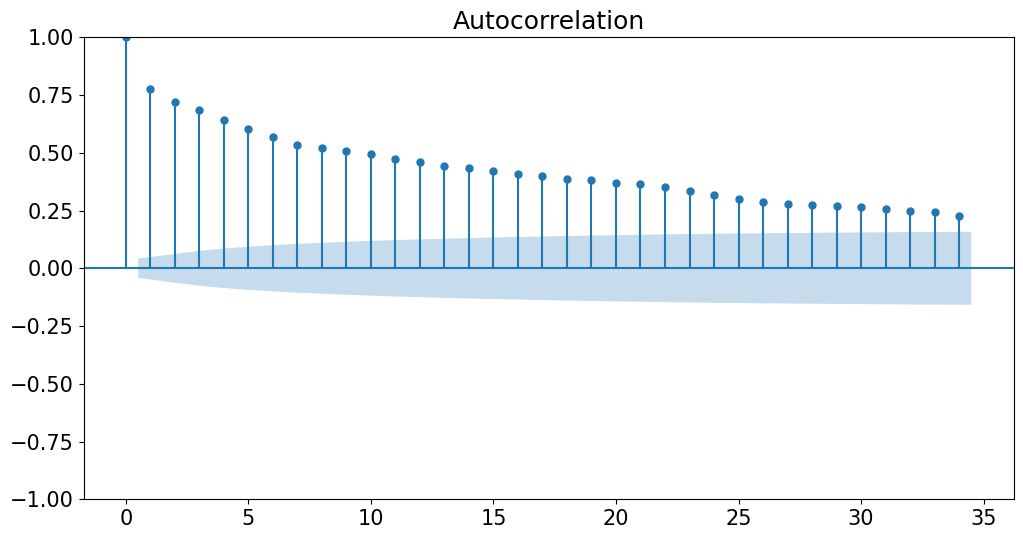

In [26]:
sm.graphics.tsa.plot_acf(df_id_5[["valeur_active"]]);

**Comment** : The ACF graph reveals that:
- our time series shows a positive correlation with its lags. There is therefore a trend
- approximately every 10 days, the quantity increases slightly before decreasing => This resembles seasonality.

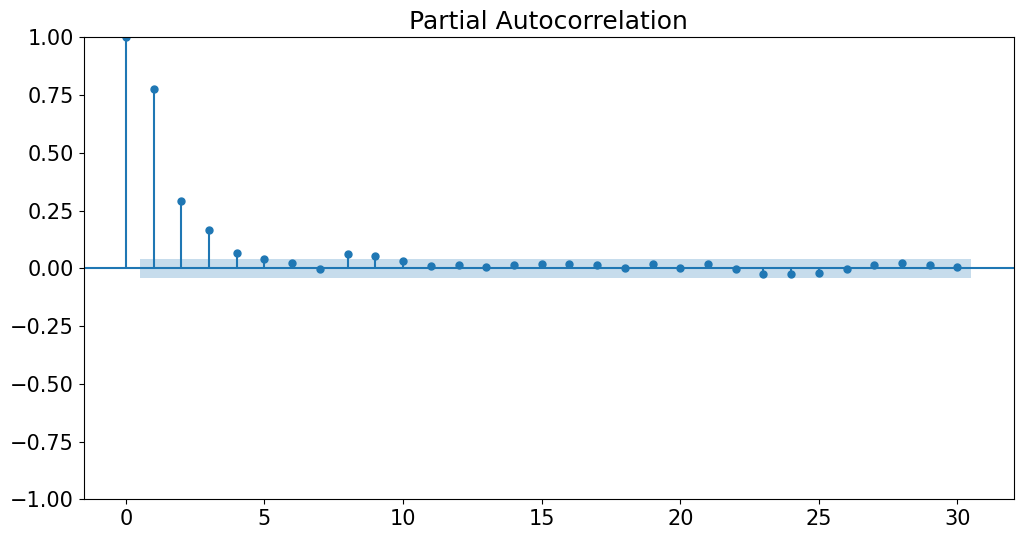

In [27]:
sm.graphics.tsa.plot_pacf(df_id_5[["valeur_active"]],lags=30);

**Comment** : The PACF graph reveals that:
- our time series shows a strong correlation with its lags 1, 2 and 3

#### Season decomposition

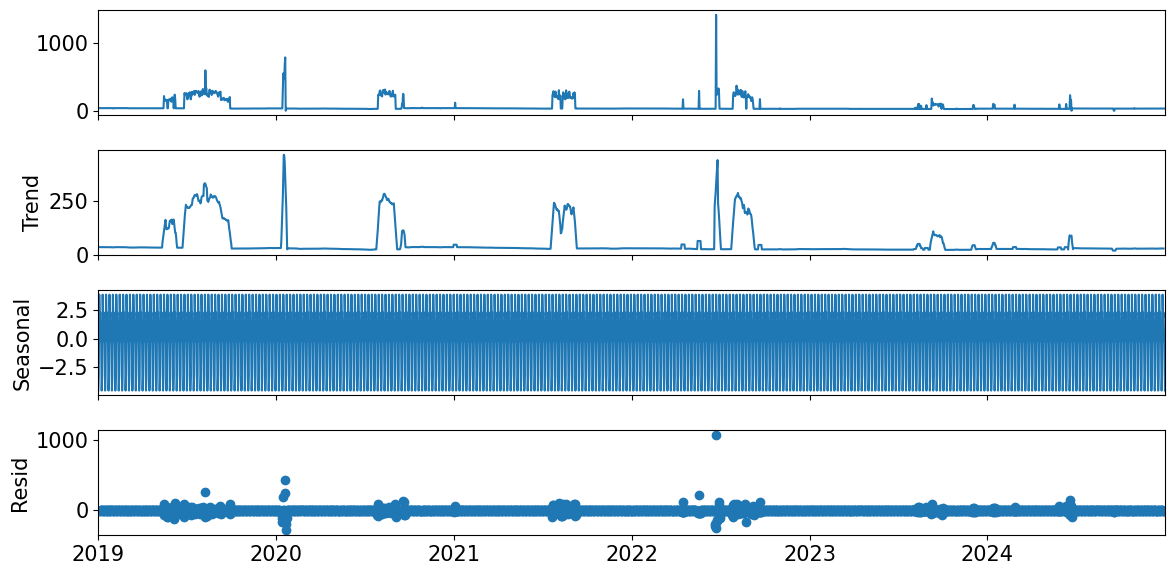

In [28]:
res = sm.tsa.seasonal_decompose(df_id_5[["valeur_active"]])
res.plot();

“Seasonal and Trend decomposition using Loess” (STL), while loess is a method for estimating nonlinear relationships.

"Flag indicating whether to use a weighted version that is robust to some forms of outliers."

Resources : 
- [link 1](https://medium.com/@kis.andras.nandor/demystifying-stl-understanding-seasonal-decomposition-of-time-series-d3c50150ec12)
- [link 2](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html)
- [link 3](https://otexts.com/fpp3/stl.html)

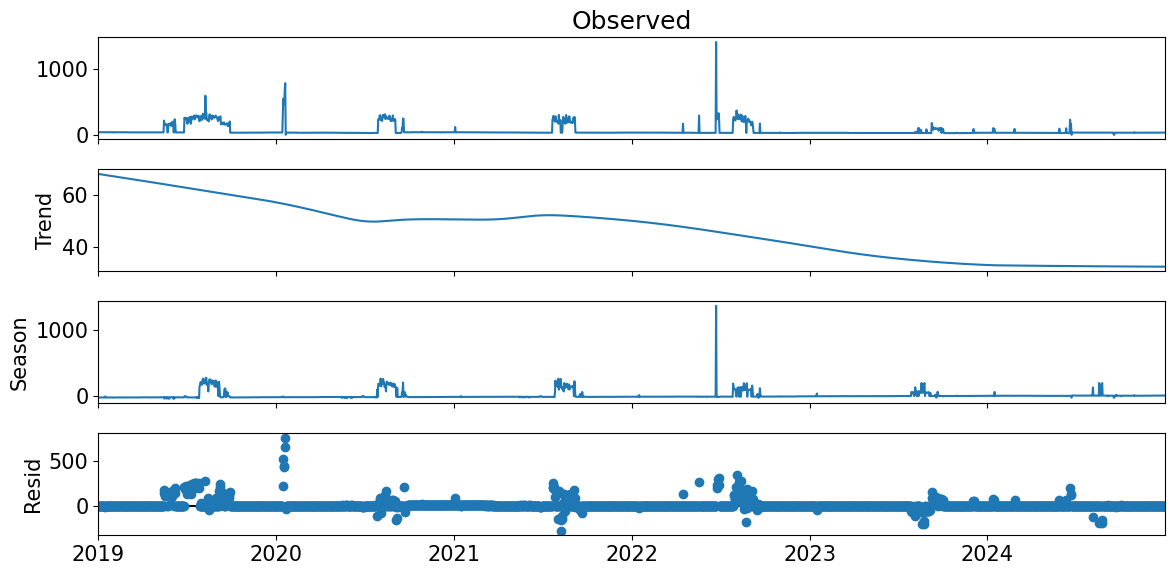

In [29]:
# Season decomposition over the days
res_days = sm.tsa.STL(df_id_5[["valeur_active"]], period=365, robust=True).fit()
res_days.plot();

/var/folders/q0/tlxqcyzj4bl5486b7j7s6ymw0000gn/T/ipykernel_43790/3934558502.py:4: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date(x, y, color='black',linestyle='--')


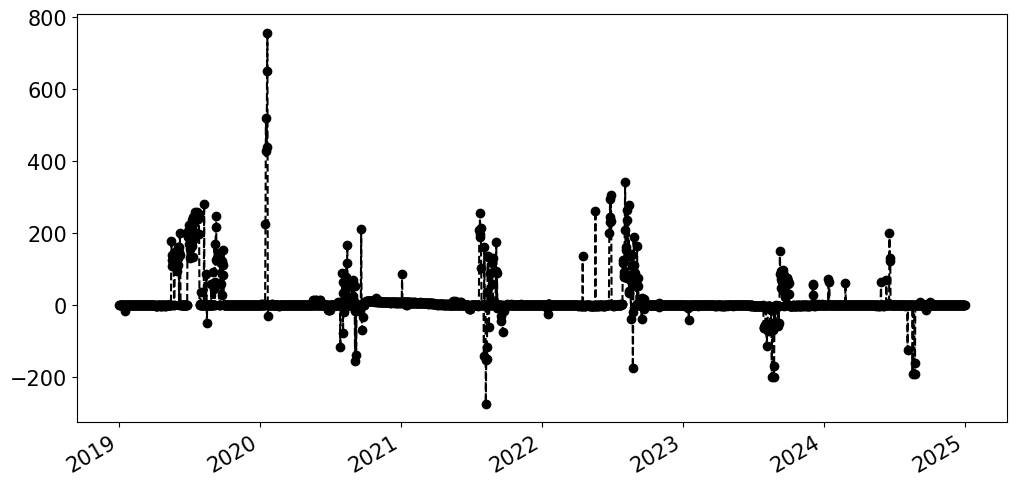

In [30]:
fig, ax = plt.subplots()
x = res_days.resid.index
y = res_days.resid.values
ax.plot_date(x, y, color='black',linestyle='--')
#ax.annotate('Anomaly', (mdates.date2num(x[35]), y[35]), xytext=(30, 20),
          #textcoords='offset points', color='red',arrowprops=dict(facecolor='red',arrowstyle='fancy'))
fig.autofmt_xdate()
plt.show()

In [31]:
base = alt.Chart(pd.DataFrame(res_days.resid))

std = base.mark_bar(interpolate="basis", color = '#5f80b8').encode(
    x=alt.X('resid', bin=alt.Bin(maxbins=40)),
    y=alt.Y('count()'))

alt.layer(std)\
    .properties(width=570, height=250)\
        .configure_title(fontSize=18)\
            .properties(title='Residual distribution over days')

alt.LayerChart(...)

**Comment** : Using a robust version for outliers, the residuals panel shows us certain outliers that may be caused by random variation or by a leak

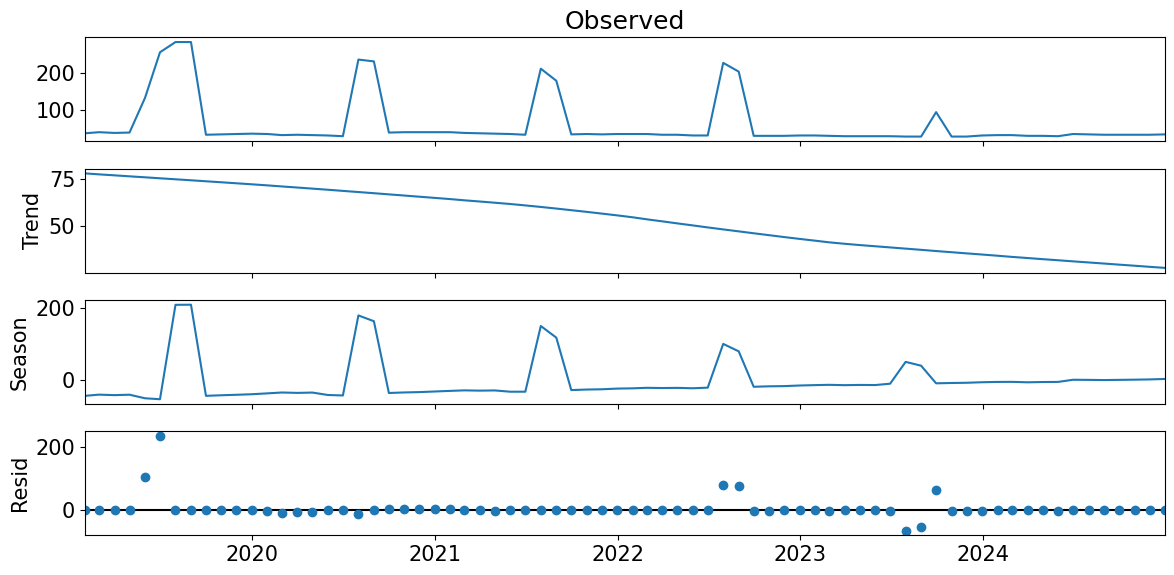

In [32]:
# Season decomposition over the month
res_month = sm.tsa.STL(df_id_5.resample('ME').ffill()[["valeur_active"]], period=12, robust=True).fit()
res_month.plot();

In [33]:
base = alt.Chart(pd.DataFrame(res_month.resid))

std = base.mark_bar(interpolate="basis", color = '#5f80b8').encode(
    x=alt.X('resid', bin=alt.Bin(maxbins=40)),
    y=alt.Y('count()'))

alt.layer(std)\
    .properties(width=570, height=250)\
        .configure_title(fontSize=18)\
            .properties(title='Residual distribution over month')

alt.LayerChart(...)

**Comment** : The residue panel allows anomalies to be identified month by month over all the years observed.
It also highlights a general downward trend. 

#### Stationarity

Resource:
- [adfuller](https://www.geeksforgeeks.org/python/how-to-check-if-time-series-data-is-stationary-with-python/)

- Ho (Null Hypothesis): The time series data is non-stationary
- H1 (alternate Hypothesis): The time series data is stationary

In [34]:
result = sm.tsa.stattools.adfuller(df_id_5["valeur_active"])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -6.457789135020765
p-value: 1.4686620923686194e-08
Critical Values: {'1%': np.float64(-3.4333504627066542), '5%': np.float64(-2.8628655035890977), '10%': np.float64(-2.567475631233297)}


**Comment** : The test result is consistent.
The amount of water varies throughout the year, so the statistics (mean, standard deviation) cannot be identical.

# Feature Engineering


This function generates several time-series features from a given column.

**Parameters**
- df (pandas.DataFrame): DataFrame containing the target column. The index must be a datetime index.
- window (int): Window size used to compute rolling statistics and create lag features.
- col_name (str): Name of the column on which the transformations are applied.

**Features Created**
- Rolling mean: rolling_mean
- Rolling standard deviation: rolling_std
- Month extracted from the datetime index: month
- Day of the week extracted from the datetime index: dayofweek
- Lag features: lag_1 up to lag_window

**Returns** : Returns the enriched DataFrame with all generated features, dropping the libelle column.

## ID_5

In [35]:
## Rolling statistics (mean and std) over a window of 10 days and month

def extract_features(df, window, col_name=x):
    df["rolling_mean"] = df[col_name].rolling(window=window).mean()
    df["rolling_std"] = df[col_name].rolling(window=window).std()
    df["month"] = df.index.month
    df["dayofweek"] = df.index.dayofweek

    for i in range(1, window+1):
        df[f"lag_{i}"] = df[col_name].shift(i)


    res = sm.tsa.STL(df[[col_name]], period=365, robust=True).fit()
    df["resid"] = res.resid.values
    df["seasonal"] = res.seasonal.values
    df["trend"] = res.trend.values

    return df.drop("libelle", axis=1)


In [38]:
X_id_5 = extract_features(df_id_5, window=10, col_name="valeur_active")
X_id_5.head(10)

,valeur_active,rolling_mean,rolling_std,month,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,resid,seasonal,trend
valeur_date,,,,,,,,,,,,,,,,,,
2019-01-01,38.0,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.694650,-29.267634,67.962283
2019-01-02,38.0,NaN,NaN,1,2,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160,-29.262489,67.933649
2019-01-03,38.0,NaN,NaN,1,3,38.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.909543,-28.995466,67.905009
2019-01-04,38.0,NaN,NaN,1,4,38.0,38.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.821831,-29.054532,67.876363
2019-01-05,38.0,NaN,NaN,1,5,38.0,38.0,38.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.824293,-29.023419,67.847711
2019-01-06,38.0,NaN,NaN,1,6,38.0,38.0,38.0,38.0,38.0,NaN,NaN,NaN,NaN,NaN,-0.915774,-28.903280,67.819054
2019-01-07,38.0,NaN,NaN,1,0,38.0,38.0,38.0,38.0,38.0,38.0,NaN,NaN,NaN,NaN,-0.877151,-28.913239,67.790390
2019-01-08,38.0,NaN,NaN,1,1,38.0,38.0,38.0,38.0,38.0,38.0,38.0,NaN,NaN,NaN,-0.879821,-28.881900,67.761721
2019-01-09,38.0,NaN,NaN,1,2,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,NaN,NaN,-0.882495,-28.850550,67.733045


## Preprocess

#### Drop missing values

In [ ]:
#X_id_5 = X_id_5.dropna()

#### Split data

In [ ]:
#X_train, X_test = train_test_split(X_id_5, test_size=0.2, shuffle=False)

#### Normalize data

In [40]:
sc = StandardScaler()
X_id_5_scaled = sc.fit_transform(X_id_5)
#X_train_normalized = min_max_scaler.fit_transform(X_train)
#X_test_normalized = min_max_scaler.transform(X_test)

# Export data

In [41]:
# save
preprocess_model = MODELS + "std_scaler.pkl"
with open(preprocess_model,'wb') as f:
    pickle.dump(sc,f)

In [43]:
#filename_training = TRAIN_PATH + "5"
#filename_test = TEST_PATH + "5"
#pd.DataFrame(X_train_normalized, columns=X_id_5.columns, index=X_train.index).to_parquet(filename_training, index=True)
#pd.DataFrame(X_test_normalized, columns=X_id_5.columns, index=X_test.index).to_parquet(filename_test, index=True)
#filename_leakage = DATASET_PATH + "5_leakage"
#pd.DataFrame(X_leakage).to_parquet(filename_leakage, index=True)

filename_dataset = DATASET_PATH + "5"
filename_dataset_scaled = DATASET_PATH + "5_scaled"

X_id_5.to_parquet(filename_dataset, index=True)
pd.DataFrame(X_id_5_scaled, columns=X_id_5.columns).to_parquet(filename_dataset_scaled, index=True)